In [458]:
import xml.etree.cElementTree as ET
import nltk
from functools import reduce
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import seaborn as sns
from scipy.stats import norm
import scipy
import numpy
import math
from matplotlib.ticker import ScalarFormatter 
import random
import word2vec
import pandas as pd
import pickle
import string

<h1>Asociación de Palabras</h1>

Definimos una función para tokenizar textos, sacando caractéres inútiles y palabras que no aportan mucho (stopwords)

In [459]:
def tokenize(text, remove_stopwords=True, allowed_words = [], lemat=False):
    stopWords = set(stopwords.words('english'))
    removable = set(["''",",''",".''",".,'","...",".,",'``','--'])
    tokens = nltk.wordpunct_tokenize(text)
    tokens = [word.lower() for word in tokens if len(word) > 1]
    tokens = [word for word in tokens 
              if ((not (word in stopWords and remove_stopwords) and not(word in removable)) or word in allowed_words) 
                  and not word.isdigit()]
    
    if lemat:
        porter_stemmer = PorterStemmer()
        tokens = [porter_stemmer.stem(word) for word in tokens]
    return tokens

In [460]:
root = ET.ElementTree(file='ap/ap.xml').getroot()

news_dic = {}
full_text = []
for node in root:
    docno, text = node
    news_dic[docno.text.strip()] = tokenize(text.text)
    full_text.append(text.text)

full_text = ' '.join(full_text)

In [461]:
tokens = tokenize(full_text)
fd = nltk.FreqDist(tokens)
most_common_s = set(sorted(fd, key=lambda x: fd[x],reverse=True)[:500])
list(most_common_s)[:10]

['thousands',
 'iraqi',
 'vice',
 'british',
 'largest',
 'hours',
 'met',
 'know',
 'proposed',
 'still']

Utilizando bigramas y una ventana de tamaño 5 calculamos los pares más asociados en base a la información mutua (pmi)

In [462]:
window_size = 5
bgm    = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_words(tokens, window_size)
finder.apply_ngram_filter(lambda w1, w2: w1 not in most_common_s or w2 not in most_common_s)
scored = finder.score_ngrams( bgm.pmi  )
scored[:10]

[(('yen', 'yen'), 8.28347572156104),
 (('prime', 'minister'), 7.841320964359447),
 (('human', 'rights'), 7.732229466436873),
 (('interest', 'rates'), 7.544580880067873),
 (('south', 'africa'), 7.431044075757306),
 (('telephone', 'interview'), 7.396305178550765),
 (('iraq', 'kuwait'), 7.368857763927906),
 (('dollar', 'yen'), 7.311175236306227),
 (('health', 'care'), 7.204085347788984),
 (('eastern', 'europe'), 7.150263561721452)]

<h1>Información Léxica</h1>

Utilizando la función definida previamente tokenizamos el texto "El origen de las especies" 

In [463]:
orig_species_f = open('ap/pg1228.txt', 'r')
inputfile = orig_species_f.read()
tokens_orig = tokenize(inputfile, False)

In [464]:
def get_apps_for_word_in_text(aWord, aText):
    return [i for i,word in enumerate(aText) if word == '{}'.format(aWord)]

instinct_app = get_apps_for_word_in_text('instinct', tokens_orig)
plant_app = get_apps_for_word_in_text('plant', tokens_orig)
for_app = get_apps_for_word_in_text('for', tokens_orig)

total_words = len(tokens_orig)

Siguiendo el análisis sobre dominios de palabras del artículo "TOWARDS THE QUANTIFICATION OF THE SEMANTIC INFORMATION ENCODED IN WRITTEN LANGUAGE", calculamos la frecuencia de las palabras "instinct", "plant" y "for" y su autocorrelación.

In [465]:
## rowo is an acronym of "rate of word occurrency"
rowo_instinct = []
rowo_plant = []
rowo_for = []

In [466]:
## Read files
for _rowo,_word in [(rowo_instinct,'instict'),(rowo_plant,'plant'),(rowo_for,'for')]:
    with open('ap/gaussian_sum_calc/{}.out'.format(_word),'rb') as fp:
        _rowo.extend(pickle.load(fp))

Distintas apariciones de las palabras "instinct", "plant" y "for"

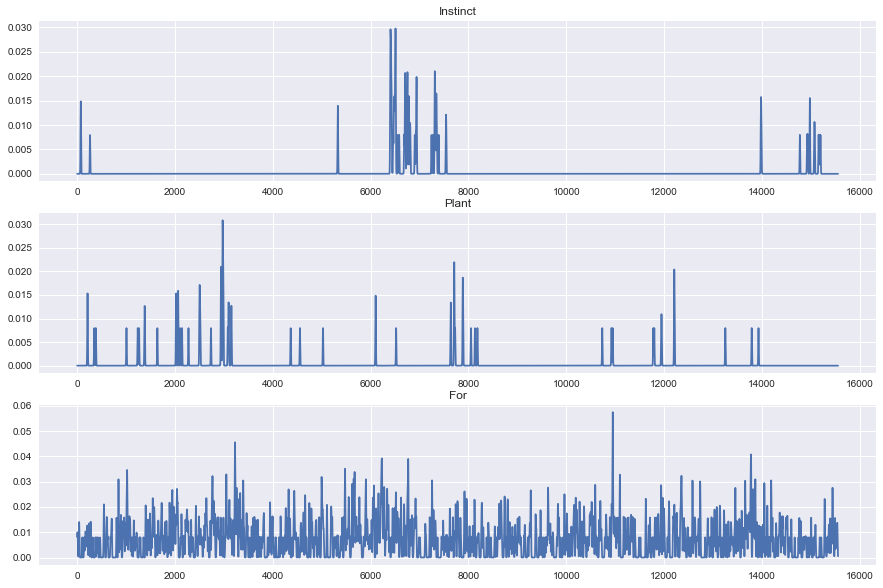

In [467]:
ax = sns.plt.subplot(311)
ax.set_title("Instinct")
sns.plt.plot(rowo_instinct)

ax = sns.plt.subplot(312)
ax.set_title("Plant")
sns.plt.plot(rowo_plant)

ax = sns.plt.subplot(313)
ax.set_title("For")
sns.plt.plot(rowo_for)
sns.plt.show()

In [468]:
def autocorrelacion(_row):
    pwt_avg = sum([ _row[pos] for pos in range(len(_row)) ]) / len(_row)
    cociente = pwt_avg**2 + sum([ _row[pos]**2 for pos in range(len(_row)) ]) / len(_row)

    taus = []

    for tau in range(1000):
        pwt_tau_avg = sum([ _row[pos]*_row[pos+tau] for pos in range(0,len(_row)-tau)]) / (len(_row)-tau)
        taus.append(pwt_tau_avg - pwt_avg * (sum([_row[pos+tau] for pos in range(0,len(_row)-tau)]) / (len(_row)-tau)))
        taus[tau] /= cociente
    return taus

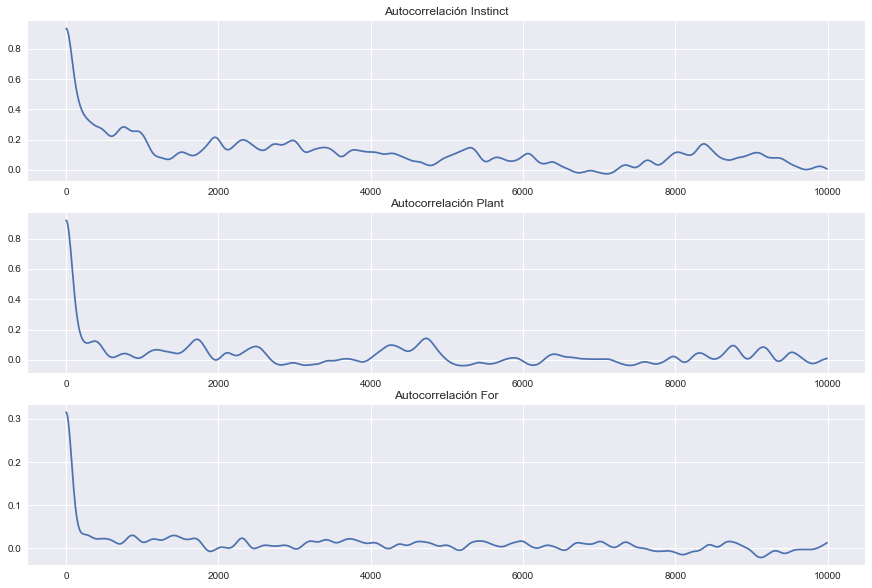

In [469]:
auto_rowo_instinct = autocorrelacion(rowo_instinct)
ax = sns.plt.subplot(311)
ax.set_title("Autocorrelación Instinct")
sns.plt.plot(range(0,10000,10),auto_rowo_instinct)

auto_rowo_plant = autocorrelacion(rowo_plant)
ax = sns.plt.subplot(312)
ax.set_title("Autocorrelación Plant")
g = sns.plt.plot(range(0,10000,10),auto_rowo_plant)

auto_rowo_for = autocorrelacion(rowo_for)
ax = sns.plt.subplot(313)
ax.set_title("Autocorrelación For")
g = sns.plt.plot(range(0,10000,10),auto_rowo_for)

sns.plt.show()

Elegimos palabras que cubren el rango de frecuencias en el texto para analizar la entropía por palabra particionando el texto en 64 partes.

In [470]:
fd_orig = nltk.FreqDist(tokens_orig)
salto = len(fd_orig)//1000
elegidas = dict()
fd_orig_s = sorted(fd_orig, key=lambda x: fd_orig[x],reverse=True)
for e in range(100):
    selection = fd_orig_s[math.floor(e**(1.5))]
    elegidas[selection] = fd_orig[selection]

list(elegidas)[:15]

['the',
 'of',
 'and',
 'that',
 'as',
 'is',
 'which',
 'from',
 'been',
 'will',
 'one',
 'each',
 'an',
 'varieties',
 'forms']

In [471]:
def freq_in_partition(w,p,p_total,text):
    desde = p*(len(text)//p_total)
    hasta = (p+1)*(len(text)//p_total)
    tot = 0
    for wt in text[desde:hasta]:
        if w==wt:
            tot += 1
    return tot

particiones = 64
entropias_orig = dict()

for w,freq in elegidas.items():
    entropia_w = 0
    for p in range(particiones):
        prob = freq_in_partition(w,p,particiones,tokens_orig)/freq
        if prob != 0:
            entropia_w += prob*(math.log(prob,2))
    entropia_w = -1*entropia_w
    entropias_orig[w] = entropia_w


tokens_shuffled = tokens_orig.copy()
random.shuffle(tokens_shuffled)
entropias_random = dict()
for w,freq in elegidas.items():
    entropia_w = 0
    for p in range(particiones):
        prob = freq_in_partition(w,p,particiones,tokens_shuffled)/freq
        if prob != 0:
            entropia_w += prob*(math.log(prob,2))
    entropia_w = -1*entropia_w
    entropias_random[w] = entropia_w

La entropía resultó más alta para el texto mezclado al azar. Parece tener sentido, ya que no se puede tener certeza de en qué particiones aparecen las palabras. Mientras que en el orden original, parece haber una idea de dominios en distintas partes del texto.

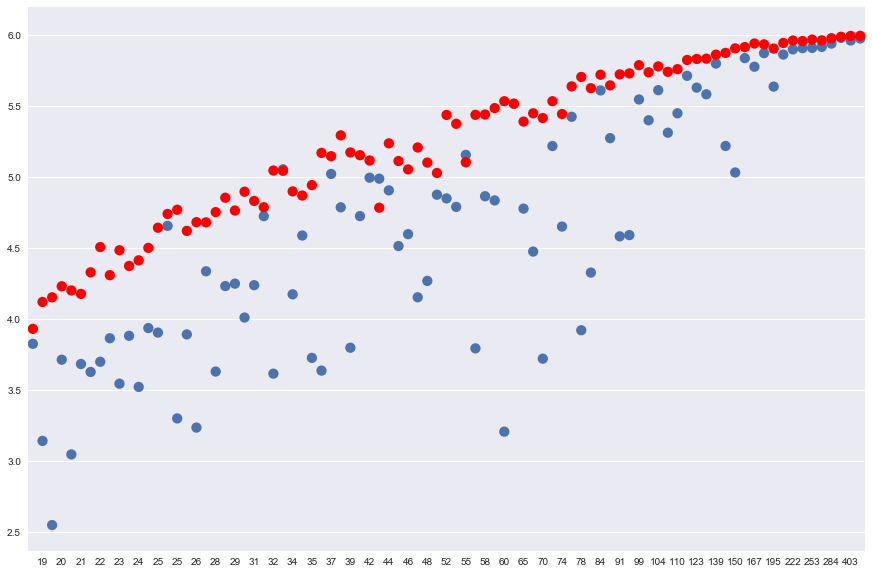

In [472]:
frequencies = []
entropies = []
entropies_shuff = []
for w,freq in elegidas.items():
    frequencies.append(freq)
    entropies.append(entropias_orig[w])
    entropies_shuff.append(entropias_random[w])

h = sns.pointplot(x=frequencies,y=entropies, join = False, ci = None)
g = sns.pointplot(x=frequencies,y=entropies_shuff, join = False, ci = None, color="red")

freq_labels = []
for i in range(len(frequencies)):
    if i % 2 == 0:
        freq_labels.append('')
    else:
        freq_labels.append(frequencies[len(frequencies)-i-1])

g.set(xticklabels=freq_labels)
sns.mpl.rc("figure", figsize=(15,10))
sns.plt.show()

<h1>Word embeddings, distancia semántica y WordNet</h1>

Realizamos comparaciónes con los valores de WordSim y las medidas de WordNet utilizando las palabras que figuran en el archivo "wordsim_similarity_goldstandard.txt" (base de datos extraída de wordsim).

Es complicado realizar las comparaciones en el sentido de que las medidas y valores se mueven en rangos distintos. Y puede darse que los mismos no sean lineales, por lo que se debería estudiar alguna manera de normalizar los valores para hacerlos comparables.

En nuestro caso, simplemente escalamos los valores para que se muevan en un rango de [0,10] y hacer una comparación sencilla.

In [473]:
from gensim import corpora, models, similarities
dictionary = corpora.Dictionary(news_dic.values())
lsi = models.LsiModel([dictionary.doc2bow(text) for text in news_dic.values()], id2word=dictionary, num_topics=4)

In [474]:
def lsi_wordsim(word1,word2,target_dictionary,target_lsi_model):    
    vec_bow1 = target_dictionary.doc2bow([word1])
    vec_bow2 = target_dictionary.doc2bow([word2])
    
    if len(vec_bow1) > 0 and len(vec_bow2) > 0:        
        vec_lsi1 = pd.DataFrame(target_lsi_model[vec_bow1],columns=['dim','val'])
        vec_lsi2 = pd.DataFrame(target_lsi_model[vec_bow2],columns=['dim','val'])
        return ((-1*scipy.spatial.distance.cosine(vec_lsi1['val'],vec_lsi2['val'])+1)+1)*5

In [475]:
model = models.Word2Vec(news_dic.values(), size=20, window=10, min_count=5, workers=4)

In [476]:
error_dict = {}

In [477]:
#Comparación con wordsim similarity goldstandard
word_sim_f = open('wordsim353_sim_rel/wordsim_similarity_goldstandard.txt')
e_w2v = 0
e_lsi = 0
res = []
for line in word_sim_f:
    w1, w2, v = line.split()
    if w1 in model.wv.vocab and w2 in model.wv.vocab:
        v = float(v)
        v_w2v = model.wv.similarity(w1, w2)*10
        v_lsi = lsi_wordsim(w1,w2,dictionary,lsi)

        e_w2v += (v_w2v - v)**2
        e_lsi += (v_lsi - v)**2
        res.append((w1,w2,v,v_w2v,v_lsi))

error_dict["wsim_standard"] = (e_lsi, e_w2v)
print("Error lsi:{}".format(e_lsi))
print("Error w2v:{}".format(e_w2v))
print("\n")
print("w1 w2 wordsim_standard w2v lsi")
for e1,e2,e3,e4,e5 in res[:10]:
    print(e1,e2,e3,e4,e5)


Error lsi:1635.472827511673
Error w2v:2049.8478053942645


w1 w2 wordsim_standard w2v lsi
tiger cat 7.35 9.73541301553 8.87817698274
tiger tiger 10.0 10.0 10.0
plane car 5.77 8.97425507516 7.88255603611
train car 6.31 9.12555977013 9.03215089945
television radio 6.77 8.78396133283 7.52008221548
media radio 7.42 8.49392909224 6.49601013627
bread butter 6.19 9.41139673752 5.69954918918
doctor nurse 7.0 9.82054982922 9.57657155165
professor doctor 6.62 9.04288585142 8.64131185231
student professor 6.81 8.76675874963 7.90270283248


In [478]:
#PATH SIMILARITY
from nltk.corpus import wordnet
word_sim_f = open('wordsim353_sim_rel/wordsim_similarity_goldstandard.txt')
e_w2v = 0
e_lsi = 0
res = []
for line in word_sim_f:
    w1, w2, _ = line.split()
    if w1 in model.wv.vocab and w2 in model.wv.vocab:
        w1_synets = wordnet.synsets(w1)[0]
        w2_synets = wordnet.synsets(w2)[0]
        v = wordnet.path_similarity(w1_synets, w2_synets)
        if not v is None:
            v = float(v)*10
            v_w2v = model.wv.similarity(w1, w2)*10
            v_lsi = lsi_wordsim(w1,w2,dictionary,lsi)

            e_w2v += (v_w2v - v)**2
            e_lsi += (v_lsi - v)**2
            res.append((w1,w2,v,v_w2v,v_lsi))

error_dict["path_similarity"] = (e_lsi, e_w2v)
print("Error lsi:{}".format(e_lsi))
print("Error w2v:{}".format(e_w2v))
print("\n")
print("w1 w2 path_similarity w2v lsi")
for e1,e2,e3,e4,e5 in res[:10]:
    print(e1,e2,e3,e4,e5)

Error lsi:5292.4184149736875
Error w2v:6293.8847299808


w1 w2 path_similarity w2v lsi
tiger cat 0.9090909090909092 9.73541301553 8.87817698274
tiger tiger 10.0 10.0 10.0
plane car 1.1111111111111112 8.97425507516 7.88255603611
train car 1.25 9.12555977013 9.03215089945
television radio 3.333333333333333 8.78396133283 7.52008221548
media radio 2.5 8.49392909224 6.49601013627
bread butter 2.5 9.41139673752 5.69954918918
doctor nurse 2.5 9.82054982922 9.57657155165
professor doctor 1.4285714285714284 9.04288585142 8.64131185231
student professor 1.25 8.76675874963 7.90270283248


In [479]:
#LCH SIMILARITY
word_sim_f = open('wordsim353_sim_rel/wordsim_similarity_goldstandard.txt')
e_w2v = 0
e_lsi = 0
for line in word_sim_f:
    w1, w2, _ = line.split()
    if w1 in model.wv.vocab and w2 in model.wv.vocab:
        w1_synets = wordnet.synsets(w1, 'n')
        w2_synets = wordnet.synsets(w2,'n')
        if len(w1_synets) != 0 and len(w2_synets) != 0:
            w1_synets = w1_synets[0]
            w2_synets = w2_synets[0]
            v = w1_synets.lch_similarity(w2_synets)
            v_w2v = model.wv.similarity(w1, w2)*10
            v_lsi = lsi_wordsim(w1,w2,dictionary,lsi)

            e_w2v += (v_w2v - v)**2
            e_lsi += (v_lsi - v)**2
            res.append((w1,w2,v,v_w2v,v_lsi))

error_dict["lch_similarity"] = (e_lsi, e_w2v)
print("Error lsi:{}".format(e_lsi))
print("Error w2v:{}".format(e_w2v))
print("\n")
print("w1 w2 lch_similarity w2v lsi")
for e1,e2,e3,e4,e5 in res[:10]:
    print(e1,e2,e3,e4,e5)

Error lsi:5034.33640272671
Error w2v:6104.191348668215


w1 w2 lch_similarity w2v lsi
tiger cat 0.9090909090909092 9.73541301553 8.87817698274
tiger tiger 10.0 10.0 10.0
plane car 1.1111111111111112 8.97425507516 7.88255603611
train car 1.25 9.12555977013 9.03215089945
television radio 3.333333333333333 8.78396133283 7.52008221548
media radio 2.5 8.49392909224 6.49601013627
bread butter 2.5 9.41139673752 5.69954918918
doctor nurse 2.5 9.82054982922 9.57657155165
professor doctor 1.4285714285714284 9.04288585142 8.64131185231
student professor 1.25 8.76675874963 7.90270283248


In [480]:
#WUP SIMILARITY
word_sim_f = open('wordsim353_sim_rel/wordsim_similarity_goldstandard.txt')

e_w2v = 0
e_lsi = 0
res = []
for line in word_sim_f:
    w1, w2, _ = line.split()
    if w1 in model.wv.vocab and w2 in model.wv.vocab:
        w1_synets = wordnet.synsets(w1)
        w2_synets = wordnet.synsets(w2)

        if len(w1_synets) != 0 and len(w2_synets) != 0:
            w1_synets = w1_synets[0]
            w2_synets = w2_synets[0]
            v = wordnet.wup_similarity(w2_synets,w1_synets)
            if v is None:
                continue
            v *= 10
            v_w2v = model.wv.similarity(w1, w2)*10
            v_lsi = lsi_wordsim(w1,w2,dictionary,lsi)
            e_w2v += (v_w2v - v)**2
            e_lsi += (v_lsi - v)**2
            res.append((w1,w2,v,v_w2v,v_lsi))

error_dict["wup_similarity"] = (e_lsi, e_w2v)
print("Error lsi:{}".format(e_lsi))
print("Error w2v:{}".format(e_w2v))
print("\n")
print("w1 w2 wup_similarity w2v lsi")
for e1,e2,e3,e4,e5 in res[:10]:
    print(e1,e2,e3,e4,e5)

Error lsi:2581.025315895363
Error w2v:2988.181629187656


w1 w2 wup_similarity w2v lsi
tiger cat 5.454545454545454 9.73541301553 8.87817698274
tiger tiger 7.5 10.0 10.0
plane car 6.666666666666666 8.97425507516 7.88255603611
train car 6.666666666666666 9.12555977013 9.03215089945
television radio 9.0 8.78396133283 7.52008221548
media radio 8.235294117647058 8.49392909224 6.49601013627
bread butter 7.5 9.41139673752 5.69954918918
doctor nurse 8.695652173913043 9.82054982922 9.57657155165
professor doctor 5.0 9.04288585142 8.64131185231
student professor 5.7142857142857135 8.76675874963 7.90270283248


In [481]:
#Res Similarity
word_sim_f = open('wordsim353_sim_rel/wordsim_similarity_goldstandard.txt')
from nltk.corpus import wordnet_ic
brown_ic = wordnet_ic.ic('ic-brown.dat')
semcor_ic = wordnet_ic.ic('ic-semcor.dat')

e_w2v_brown = 0
e_lsi_brown = 0
e_w2v_semcor = 0
e_lsi_semcor = 0
res = []
for line in word_sim_f:
    w1, w2, _ = line.split()
    if w1 in model.wv.vocab and w2 in model.wv.vocab:
        w1_synets = wordnet.synsets(w1,'n')
        w2_synets = wordnet.synsets(w2,'n')
        if len(w1_synets) != 0 and len(w2_synets) != 0:
            w1_synets = w1_synets[0]
            w2_synets = w2_synets[0]
            v1 = w1_synets.lin_similarity(w2_synets,brown_ic)*10
            v2 = w1_synets.lin_similarity(w2_synets,semcor_ic)*10
            v_w2v = model.wv.similarity(w1, w2)*10
            v_lsi = lsi_wordsim(w1,w2,dictionary,lsi)
        
            e_lsi_brown += (v_lsi - v1)**2
            e_w2v_brown += (v_w2v - v1)**2
            e_lsi_semcor += (v_lsi - v2)**2
            e_w2v_semcor += (v_w2v - v2)**2
            
            res.append((w1,w2,v1,v2,v_w2v,v_lsi))

error_dict["lin_brown"] = (e_lsi_brown, e_w2v_brown)
error_dict["lin_semcor"] = (e_lsi_semcor, e_w2v_semcor)
print("Error lsi_brown:{}".format(e_lsi_brown))
print("Error w2v_brown:{}".format(e_w2v_brown))
print("Error lsi_semcor:{}".format(e_lsi_semcor))
print("Error w2v_semcor:{}".format(e_w2v_semcor))
print("\n")
print("w1 w2 lin_brown lin_semcor w2v lsi")
for e1,e2,e3,e4,e5,e6 in res[:10]:
    print(e1,e2,e3,e4,e5,e6)

Error lsi_brown:4458.060346192395
Error w2v_brown:5093.228638405607
Error lsi_semcor:4532.995510501868
Error w2v_semcor:5309.087345479473


w1 w2 lin_brown lin_semcor w2v lsi
tiger cat 2.0875196749630205 1.7876537608969536 9.73541301553 8.87817698274
tiger tiger 10.0 10.0 10.0 10.0
plane car 7.194339072268571 7.415075613737301 8.97425507516 7.88255603611
train car 6.786666052669672 7.130136772224251 9.12555977013 9.03215089945
television radio 9.036510587018252 9.042487767179926 8.78396133283 7.52008221548
media radio 8.322760066971366 8.28128488829231 8.49392909224 6.49601013627
bread butter 7.114204901462941 7.26992234769291 9.41139673752 5.69954918918
doctor nurse 8.351534747090344 7.806329292826345 9.82054982922 9.57657155165
professor doctor 7.036526610448273 7.770369763910114 9.04288585142 8.64131185231
student professor 2.6208607023317687 2.3953150362674096 8.76675874963 7.90270283248


Parece que en general el modelo LSI se comporta mejor que W2V. Hay que tener en cuenta que W2V no fue entrenado de la mejor manera y que no podemos definir hasta que punto son comparables las medidas. Pero como una aproximación los resultados son interesantes.

In [482]:
print("Medida\t\t\t\tLSI\t\t\tW2V")
for k,v in error_dict.items():
    print("{}\t\t{}\t{}".format(k,v[0],v[1]))

Medida				LSI			W2V
wsim_standard		1635.472827511673	2049.8478053942645
path_similarity		5292.4184149736875	6293.8847299808
lch_similarity		5034.33640272671	6104.191348668215
wup_similarity		2581.025315895363	2988.181629187656
lin_brown		4458.060346192395	5093.228638405607
lin_semcor		4532.995510501868	5309.087345479473
